# Advanced Text Generation Techniques and Tools

Going beyond prompt engineering, there are several areas where we can improve the quality of generated text:

- Model I/O
- Memory
- Agents
- Chains

[Langchain](https://www.langchain.com/) is a framework that provides useful abstractions for these kinds of things and helps connect them together. We will use LangChain here, but alternatives include LlamaIndex, DSPy and Haystack.

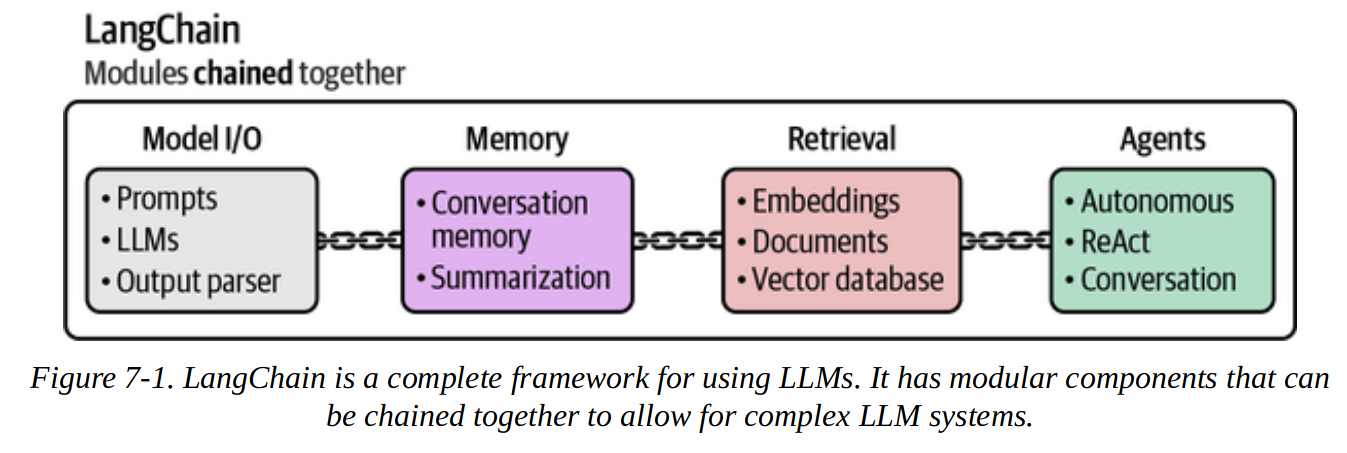


# 1. Model I/O
## 1.1. Quantization

We can load **quantized models** using the [GGUF file format](https://github.com/ggml-org/ggml/blob/master/docs/gguf.md) which is a binary format optimised for fast loading of pytorch models.

The benefit of a quantized model is a smaller size in memory while retaining *most* of the original information. For example, if the model was trained using 32-bit floats for parameters, we can use 16-bit floats instead. This reduces the memory requirement but also reduces the precision. Often this trade-off is worthwhile.

[This page](https://newsletter.maartengrootendorst.com/p/a-visual-guide-to-quantization) goes into detail on the mechanics of quantisation.

The "best" model is constantly changing, so we can refer to the [Open LLM leaderboard](https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard#/).

We can download a 16-bit quantized version of the Phi-3 mini model from HuggingFace.

In [ ]:
!wget https://huggingface.co/microsoft/Phi-3-mini-4k-instructgguf/resolve/main/Phi-3-mini-4k-instruct-fp16.gguf

Then we can use LangChain to load the GGUF file:

In [ ]:
from langchain import LlamaCpp 

# Make sure model_path points at the file location of the GGUF file
llm = LlamaCpp(
    model_path="Phi-3-mini-4k-instruct-fp16.gguf",
    n_gpu_layers=-1,
    max_tokens=500,
    n_ctx=2048,
    seed=42,
    verbose=False
)

# 2. Chains
## 2.1. Basic Prompt Chain

In LangChain, we use the `invoke` function to generate an output. 

However, each model requires a specific prompt template. If we blindly called `invoke` on our model, we get no response:

In [ ]:
llm.invoke("Hi! My name is Gurp. What is 1 + 1?")

This is where the LangChain abstractions come in useful.

We will create a simple chain with a single link:

```{mermaid}
flowchart LR

  subgraph PromptChain
    B(Prompt template) --> C[LLM]
  end

  A(User prompt) --> B
  C --> D(Output)
```

For our particular case, Phi-3 prompts require start, end , user and assistant tokens.

In [ ]:
from langchain import PromptTemplate 

# Create a prompt template with the "input_prompt" variable 
template = """<s><|user|> {input_prompt}<|end|> <|assistant|>""" 
prompt = PromptTemplate(template=template, input_variables=["input_prompt"])

We can then create a chain by chaining the prompt and LLM together. Then we can call `invoke` and get the intended text generation.

In [ ]:
basic_chain = prompt | llm
basic_chain.invoke({"input_prompt": "Hi! My name is Maarten. What is 1 + 1?"})

Note that we just passed the entire `input_prompt` as a variable to the chain, but we can define other variables. For example, if we wanted a more specialised use case where we don't give te user as much flexibility, we can pre-define some of the prompt.

```python
template = "Create a funny name for a business that sells {product}." 
name_prompt = PromptTemplate(template=template, input_variables=["product"])
```

## 2.2. Multiple Prompt Chain

If we have more complex prompts or use cases, we can split the task into smaller subtasks that run sequentially. Each link in the chain deals with a specific subtask.

```{mermaid}
flowchart LR

  subgraph MultiPromptChain
    B1(Prompt 1) --> B2(Prompt 2)
    B1 <--> C[LLM]
    B2 <--> C
  end

  A(User input) --> B1

  B2 --> D(Output)
```

As an example, we can prompt the LLM to create a story. First we ask it for a title based on the user prompt, then characters based on the title, then a story based on the characters and title. The first link is the only one that requires user input.

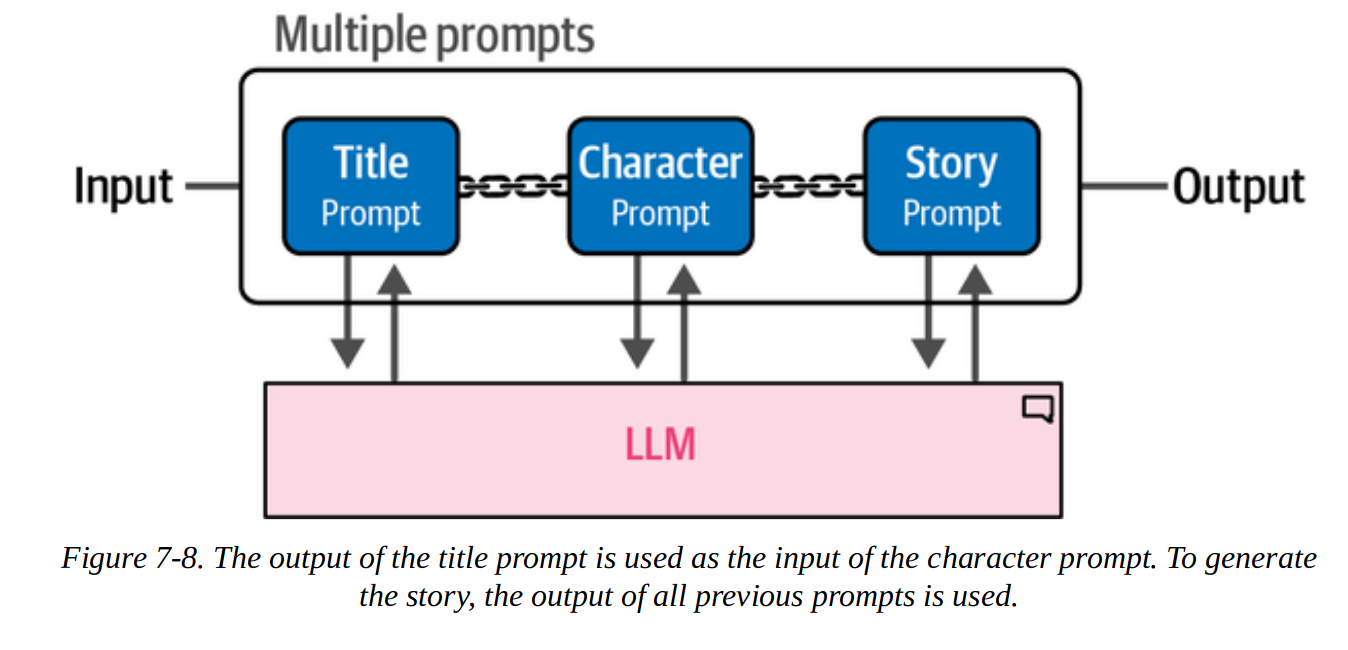

In [ ]:
from langchain import LLMChain

# Create a chain for the title of our story 
template = """<s><|user|> Create a title for a story about {summary}. Only return the title. <|end|> <|assistant|>""" 
title_prompt = PromptTemplate(template=template, input_variables= ["summary"]) 
title = LLMChain(llm=llm, prompt=title_prompt, output_key="title")

# Create a chain for the character description using the summary and title 
template = """<s><|user|> Describe the main character of a story about {summary} with the title {title}. Use only two sentences.<|end|> <|assistant|>""" 
character_prompt = PromptTemplate(template=template, input_variables=["summary", "title"]) 
character = LLMChain(llm=llm, prompt=character_prompt, output_key="character")

# Create a chain for the story using the summary, title, and character description 
template = """<s><|user|> Create a story about {summary} with the title {title}. The main character is: {character}. Only return the story and it cannot be longer than one paragraph. <|end|> <|assistant|>""" 
story_prompt = PromptTemplate(template=template, input_variables=["summary", "title", "character"]) 
story = LLMChain(llm=llm, prompt=story_prompt, output_key="story")


# Combine all three components to create the full chain 
llm_chain = title | character | story

Noe we can invoke the chain just like before:

llm_chain.invoke("a dog that can smell danger")

# 3. Memory

By default, most LLMs will not remember what was said previously in the conversation.
For example, if you give your name in one prompt, it will not be able to recall it later.

In [ ]:
# Let's give the LLM our name 
basic_chain.invoke({"input_prompt": "Hi! My name is Gurp. What is 1 + 1?"})

In [ ]:
# Next, we ask the LLM to reproduce the name

basic_chain.invoke({"input_prompt": "What is my name?"})

Models are **stateless**; they do not store memory.
We can add specific types of memory to the chain to help it "remember" conversations:

- Conversation buffer
- Conversation summary

## 3.1. Conversation Buffer

The simplest way we can force the LLM to remember previous conversation is by **passing the full conversation history in our prompt**.

This approach is called conversation buffer memory. We update our prompt with the history of the chat.

### 3.1.1. Simple Conversation Buffer

In [ ]:
# Create an updated prompt template to include a chat history 
template = """<s><|user|>Current conversation:{chat_history} {input_prompt}<|end|> <|assistant|>""" 
prompt = PromptTemplate(template=template, input_variables=["input_prompt", "chat_history"])

Next, we create a `ConversationBufferMemory` link in the chain that will store the conversations we have previously had with the LLM.

In [ ]:
from langchain.memory import ConversationBufferMemory

# Define the type of memory we will use 
memory = ConversationBufferMemory(memory_key="chat_history") 

# Chain the LLM, prompt, and memory together 
llm_chain = LLMChain(prompt=prompt, llm=llm, memory=memory)

We can verify if this has worked by seeing if it now remembers our name in later prompts:

In [ ]:
# Generate a conversation and ask a basic question 
llm_chain.invoke({"input_prompt": "Hi! My name is Gurp. What is 1 + 1?"})

In [ ]:
# Does the LLM remember my name? 
llm_chain.invoke({"input_prompt": "What is my name?"})

### 3.1.2 Windowed Conversation Buffer

As the conversation goes on, the size of the chat history grows until eventually it may exceed the token limit.

One approach to work around this is to only hold the last $k$ conversations in memory rather than the entire history.

In [ ]:
from langchain.memory import ConversationBufferWindowMemory 

# Retain only the last 2 conversations in memory 
memory = ConversationBufferWindowMemory(k=2, memory_key="chat_history") 

# Chain the LLM, prompt, and memory together 
llm_chain = LLMChain(prompt=prompt, llm=llm, memory=memory)

This approach is not ideal for longer conversations. An alternative is to **summarise** the chat history to fit in the token limit, rather than truncating it.


## 3.2. Conversation Summary

This approach uses an LLM to summarise the main points of the history so far to reduce the number of tokens required to pass to the main LLM.

The "summary LLM" can be a different model to our "main LLM". We may want to use a smaller LLM for the "easier" task of summarisation to speed up computation.

There will now be two LLM calls per invocation: the user prompt and the summarisation prompt.

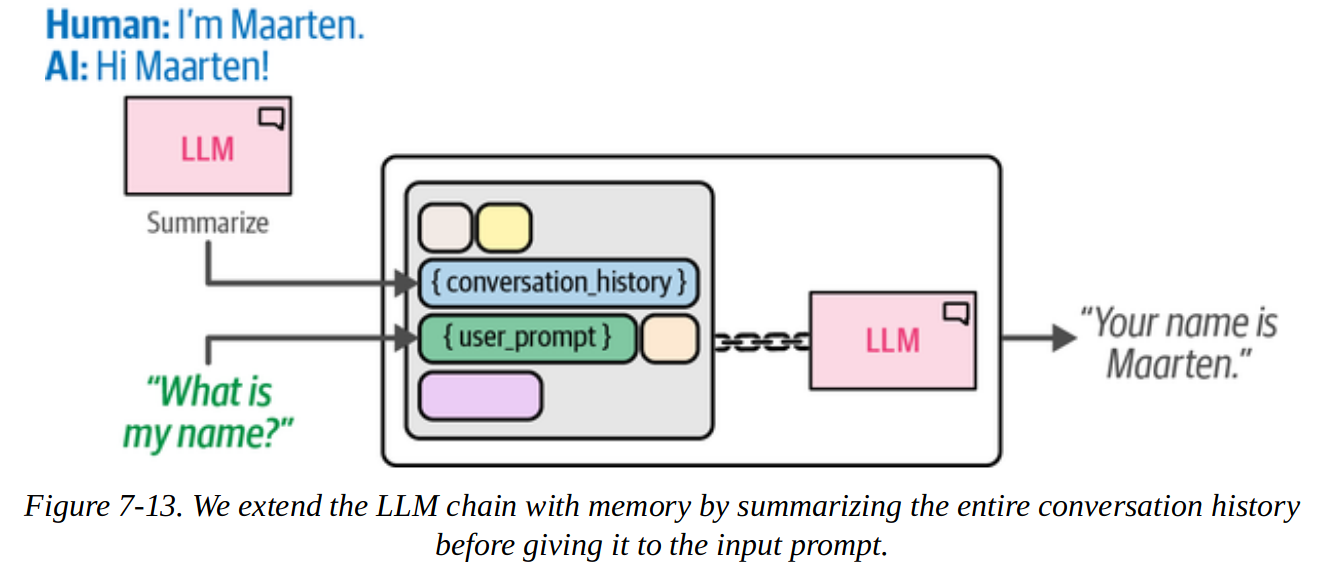

In [ ]:
# Create a summary prompt template 
summary_prompt_template = """
    <s><|user|>Summarize the conversations and update with the new lines. 
    Current summary: {summary} new lines of conversation: {new_lines} 
    New summary:<|end|> <|assistant|>
"""
summary_prompt = PromptTemplate(
    input_variables=["new_lines", "summary"],
    template=summary_prompt_template
)

In this example, we'll pass both calls to the same LLM, but in general we don't have to.

In [ ]:
from langchain.memory import ConversationSummaryMemory 

# Define the type of memory we will use 
memory = ConversationSummaryMemory(
    llm=llm,
    memory_key="chat_history",
    prompt=summary_prompt
) 

# Chain the LLM, prompt, and memory together 
llm_chain = LLMChain(prompt=prompt, llm=llm, memory=memory)

We can try this out by having a short conversation with the LLM and checking it has retained previous information.

In [ ]:
# Generate a conversation and ask for the name 
llm_chain.invoke({"input_prompt": "Hi! My name is Gurp. What is 1 + 1?"}) 
llm_chain.invoke({"input_prompt": "What is my name?"})

In [ ]:
# Check whether it has summarized everything thus far 
llm_chain.invoke({"input_prompt": "What was the first question I asked?"})

In [ ]:
# Check what the summary is thus far 
memory.load_memory_variables({})

The conversation summary approach reduces the tokens required, but it does risk losing information depending on the quality of the summary.

## 3.3. Comparison of Memory Approaches

**Conversation buffer**
Pros:

- Easiest to implement
- Ensures *no loss of info* (as long as conversation fits in congtext window)

Cons:

- *Slower generation* (more tokens needed)
- Only suitable for LLMs with large context windows
- Handles larger chat histories poorly


**Windows conversation buffer**
Pros:

- Can use LLMs with smaller context windows
- Good for shorter chats; no information loss over the last k interactions

Cons:

- *Only captures k interactions*
- No compression, so can still require a large context window if k is large


**Conversation summary**
Pros:

- Captures *full history*
- Enables long chats
- Reduces required tokens

Cons: 

- Requires an *additional LLM call* per interaction
- Quality of response depends on LLM's summarisation quality

# 4. Agents

We can think of agents as an extension of multiple prompt chains.
The difference is rather than requiring a user to input multiple prompts, *the LLM decides* on what actions it should take and in which order.
Understanding both the query and **deciding which tool to use and when** is the crux of what makes agents useful.

Agents can make use of all the tools so far, including chains and memory.
Two more that are vital for agents are:

- **Tools** that the agent uses to do things it cannot do by itself
- The **agent type** wich plans the actions to take (and the tools to use)

Agents show more advanced behaviour like creating and self-correcting a roadmap to achieve a goal, and they can interact with the real world through tools.

## 4.1. ReAct
Many agent-based systems rely on the **ReAct** framework, which standard for **Re**asoning and **Act**ing.

We can give the LLM the ability to use tools, but it can only generate text, so it needs to generate the right text to interact with tools.
For example, if we let it use a weather forecasting API, it needs to provide a request in the correct format.

ReAct merges the concepts of reasoning and acting as they are essentially two sides of the same coin: we want reasonong to afect actions and actions to affect reasoning.
It does this by iteratively following these three steps:

1. Thought
2. Action
3. Observation

We incorporate this into a prompt template like so:

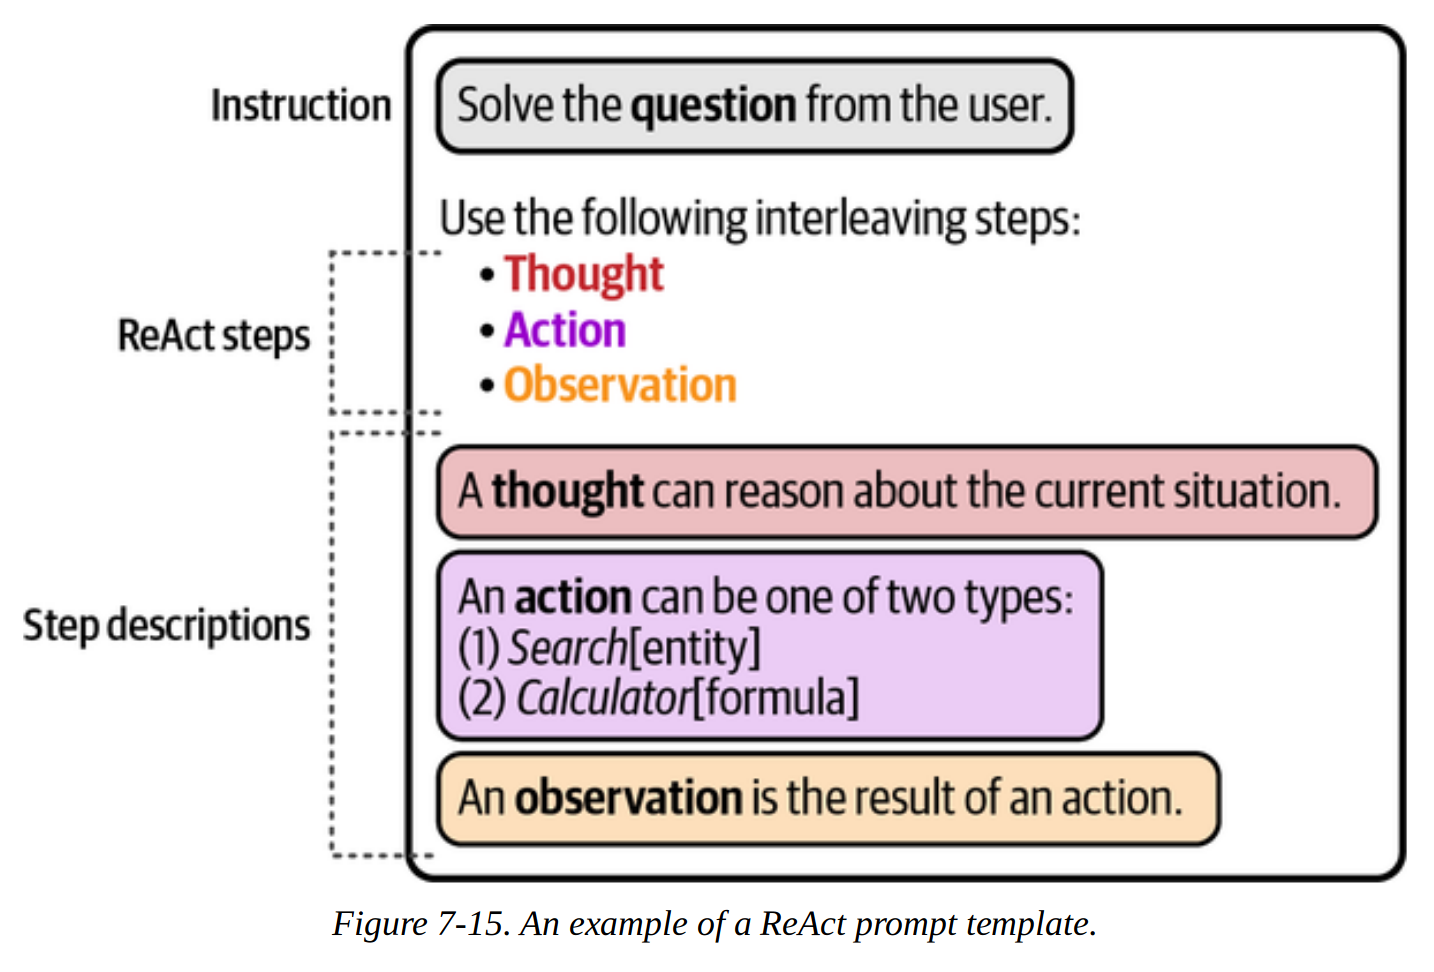

We ask it to create a thought about the prompt, then trigger an action based on the thought, then observe the output, i.e. whatever it retrieved from an external tool.

An example of this is using ChatGPT to use a calculator.

In [ ]:
import os 
from langchain_openai import ChatOpenAI 

# Load OpenAI's LLMs with LangChain 
os.environ["OPENAI_API_KEY"] = "MY_KEY" 
openai_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [ ]:
# Create the ReAct template 

react_template = """
    Answer the following questions as best you can. 
    You have access to the following tools: {tools} 
    
    Use the following format: 
    
    Question: the input question you must answer 
    Thought: you should always think about what to do 
    Action: the action to take, should be one of [{tool_names}] 
    Action Input: the input to the action 
    Observation: the result of the action ... (this Thought/Action/Action Input/Observation can repeat N times) 
    Thought: I now know the final answer 
    Final Answer: the final answer to the original input question
    
    Begin! 
    
    Question: {input} 
    Thought:{agent_scratchpad}
""" 
    
prompt = PromptTemplate(
    template=react_template,
    input_variables=["tools", "tool_names", "input", "agent_scratchpad"]
)

Next we need to define the tools it can use to interact with the outside world.

In [ ]:
from langchain.agents import load_tools, Tool 
from langchain.tools import DuckDuckGoSearchResults 

# You can create the tool to pass to an agent 
search = DuckDuckGoSearchResults() 
search_tool = Tool(
    name="duckduck",
    description="A web search engine. Use this to as a search engine for general queries.",
    func=search.run
)

# Prepare tools 
tools = load_tools(["llm-math"], llm=openai_llm)   # Calculator tool is included by default 
tools.append(search_tool)

Finally we can create the ReAct agent and pass it to the `AgentExecutor` which handles the execution steps.

In [ ]:
from langchain.agents import AgentExecutor, create_react_agen

# Construct the ReAct agent 
agent = create_react_agent(openai_llm, tools, prompt) 
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True
)

Now we can invoke the LLM to find the price of an item and convert the currency. It will choose the appropriate tools to use for this.

In [ ]:
# What is the price of a MacBook Pro? 
agent_executor.invoke({
    "input": "What is the current price of a MacBook Pro in USD? How much would it cost in EUR if the exchange rate is 0.85 EUR for 1 USD."
})

The agent generates intermediate steps during execution which we can use to follow its train of thought.

The important thing to consider when using agents is that there is **no human in the loop**; it will generate *an answer* but there is no guarantee that it is the *correct answer*.

We can make some tweaks to help ourselves debug this. For exampe, asking the agent to return the website's URL that it retrieved prices from to make manual verification easier. 

# References

- Chapter 7 of Hands-On Large Language Models by Jay Alammar & Marten Grootendoorst
- [Langchain docs](https://www.langchain.com/)
- [GGUF file format](https://github.com/ggml-org/ggml/blob/master/docs/gguf.md)
- [Visual guide to quantization](https://newsletter.maartengrootendorst.com/p/a-visual-guide-to-quantization)
- [Open LLM leaderboard](https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard#/)